In [1]:
"""
Generating target function, featurizer, and train/validation/test splits for the Lasso homework.

Author: David S. Rosenberg <david.davidr@gmail.com>
License: Creative Commons Attribution 4.0 International License
"""

from sklearn.model_selection import train_test_split
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle


def step_fn_generator(stepLoc=0):
    def f(x):
        ret = np.zeros(len(x))
        ret[x >= stepLoc] = 1
        return ret
    return f

def linear_comb_generator(fns, coefs):
    def f(x):
        return sum(fns[i](x) * coefs[i] for i in range(len(fns)))
    return f

def get_target_and_featurizer(num_basis_fns = 100, num_nonzero = 10, coefs_true=None):
    # We'll create a basis of step functions on the interval [0,1]. We'll then
    # construct a linear combination of these step functions to be our target
    # function. We'll construct a function to "featurize" an input in [0,1]
    # into the evaluations of all functions in the basis on the input.
    # Optionally: If coefs_true is provided, they will be used to generate
    # target_fn and featurize.
    # Construct basis, to be used for generating target function

    if coefs_true is not None:
        num_basis_fns = len(coefs_true)
    else:
        nonzero_indices = np.random.choice(num_basis_fns, num_nonzero)
        coefs_true = np.zeros(num_basis_fns)
        coefs_true[nonzero_indices] = np.random.randn(num_nonzero)

    all_basis_fns = [step_fn_generator(stepLoc=s)
                     for s in np.linspace(0, 1, num_basis_fns, endpoint=False)]

    # Construct target function (the Bayes prediction function)
    target_fn = linear_comb_generator(all_basis_fns, coefs_true)

    def featurize(x):
        n = len(x)
        # Featurize input values in [0,1]
        X_ftrs = np.empty((n, num_basis_fns))
        for ftr_num in range(num_basis_fns):
            X_ftrs[:, ftr_num] = all_basis_fns[ftr_num](x)
        return X_ftrs

    return target_fn, coefs_true, featurize

def generate_data(target_fn, n=1000, noise_scale=.25, tdof=6):
    # Construct dataset
    x = np.sort(np.random.rand(n)) #chooses uniformly from [0,1)
    y_target = target_fn(x)
    y = y_target + noise_scale * np.random.standard_t(tdof,n)
    return x, y

def get_data_splits(x, y, test_frac=.2):
    ## Based on https://github.com/ageron/handson-ml/blob/master/02_end_to_end_machine_learning_project.ipynb
    n = len(y)
    shuffled_indices = np.random.permutation(n)
    n_test = int(n * test_frac)
    n_train = n - n_test
    indices_test = shuffled_indices[:n_test]
    indices_train = shuffled_indices[n_test:]
    y_train = y[indices_train]
    x_train = x[indices_train]
    y_test = y[indices_test]
    x_test = x[indices_test]
    return x_train, y_train, x_test, y_test

def generate_problem(n=200, num_basis_fns=400, num_nonzero=10, noise_scale=.25, tdof=6, test_frac=.2, write_problem=False, file_name="lasso_data.pickle"):
    target_fn, coefs_true, featurize = get_target_and_featurizer(num_basis_fns, num_nonzero)
    x, y = generate_data(target_fn, n, noise_scale, tdof)
    x_train, y_train, x_test, y_test = get_data_splits(x, y, test_frac)

    if write_problem:
        print ("Saving problem to disk.")
        data = {"coefs_true":coefs_true, "x_train":x_train,
                "y_train":np.copy(y_train), "x_test":x_test, "y_test":y_test}
        with open(file_name, 'wb') as outfile:
            pickle.dump(data, outfile, protocol=2)

    return x_train, y_train, x_test, y_test, target_fn, coefs_true, featurize

def reconstitute_problem(coefs_true, x_train, y_train, x_test, y_test):
    target_fn, coefs_true, featurize = get_target_and_featurizer(coefs_true=coefs_true)
    return x_train, y_train, x_test, y_test, target_fn, coefs_true, featurize

def load_problem(file_name):
    f_myfile = open(file_name, 'rb')
    data = pickle.load(f_myfile)
    f_myfile.close()
    return reconstitute_problem(data["coefs_true"], data["x_train"], data["y_train"],
                                data["x_test"], data["y_test"])

def main():
    lasso_data_fname = "lasso_data.pickle"
    LOAD_PROBLEM=True
    GENERATE_PROBLEM=False
    WRITE_PROBLEM=False
    if GENERATE_PROBLEM:
        n=1000
        test_fra=.9
        num_basis_fns=400
        num_nonzero=10
        noise_scale=.25 # scale factor on noise
        tdof = 6 # degrees of freedom of t-distribution generating noise
        x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = generate_problem(n=n, num_basis_fns=num_basis_fns, num_nonzero=num_nonzero, noise_scale=noise_scale, test_frac=test_frac, write_problem=WRITE_PROBLEM, file_name=lasso_data_fname)

    if LOAD_PROBLEM:
        x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(lasso_data_fname)

    # Let's plot the target function (i.e. the Bayes prediction function) as
    # well as the noisy observations from the training data, as a function of
    # the original input space, which is the interval [0,1).
    fig, ax = plt.subplots()
    plt.scatter(x_train, y_train, s=3, color='k', label='Training data')
    x = np.arange(0,1,.001)
    ax.plot(x, target_fn(x), 'r', label='Target function (i.e. Bayes prediction function)')
    legend = ax.legend(loc='upper center', shadow=True)
    plt.show(block=False)

if __name__ == '__main__':
    main()

<Figure size 640x480 with 1 Axes>

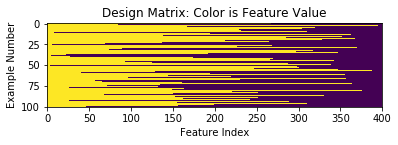

Hoping this is very close to 0:4.6884282980897267e-11
    param_l2reg  mean_test_score  mean_train_score
0      0.000001         0.172579          0.006752
1      0.000010         0.172464          0.006752
2      0.000100         0.171345          0.006774
3      0.001000         0.162705          0.008285
4      0.010000         0.141887          0.032767
5      0.100000         0.144566          0.094953
6      1.000000         0.171068          0.197694
7      1.300000         0.179521          0.216591
8      1.600000         0.187993          0.233450
9      1.900000         0.196361          0.248803
10     2.200000         0.204553          0.262958
11     2.500000         0.212530          0.276116
12     2.800000         0.220271          0.288422


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


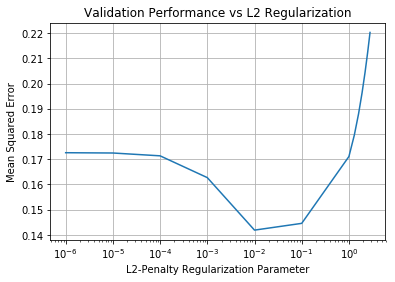

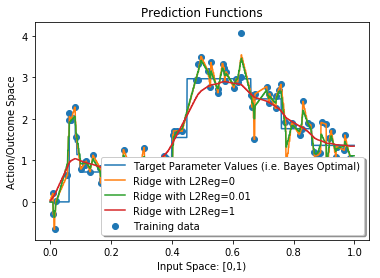

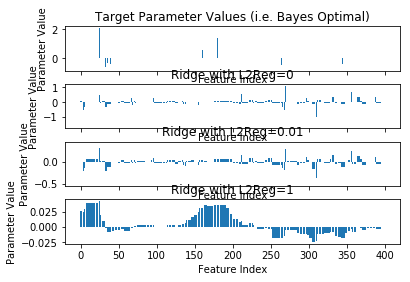

In [2]:
"""
Ridge regression using scipy's minimize function and demonstrating the use of
sklearn's framework.

Author: David S. Rosenberg <david.davidr@gmail.com>
License: Creative Commons Attribution 4.0 International License
"""
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd

from setup_problem import load_problem

class RidgeRegression(BaseEstimator, RegressorMixin):
    """ ridge regression"""

    def __init__(self, l2reg=1):
        if l2reg < 0:
            raise ValueError('Regularization penalty should be at least 0.')
        self.l2reg = l2reg

    def fit(self, X, y=None):
        n, num_ftrs = X.shape
        # convert y to 1-dim array, in case we're given a column vector
        y = y.reshape(-1)
        def ridge_obj(w):
            predictions = np.dot(X,w)
            residual = y - predictions
            empirical_risk = np.sum(residual**2) / n
            l2_norm_squared = np.sum(w**2)
            objective = empirical_risk + self.l2reg * l2_norm_squared
            return objective
        self.ridge_obj_ = ridge_obj

        w_0 = np.zeros(num_ftrs)
        self.w_ = minimize(ridge_obj, w_0).x
        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        return np.dot(X, self.w_)

    def score(self, X, y):
        # Average square error
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        residuals = self.predict(X) - y
        return np.dot(residuals, residuals)/len(y)



def compare_our_ridge_with_sklearn(X_train, y_train, l2_reg=1):
    # First run sklearn ridge regression and extract the coefficients
    from sklearn.linear_model import Ridge
    # Fit with sklearn -- need to multiply l2_reg by sample size, since their
    # objective function has the total square loss, rather than average square
    # loss.
    n = X_train.shape[0]
    sklearn_ridge = Ridge(alpha=n*l2_reg, fit_intercept=False, normalize=False)
    sklearn_ridge.fit(X_train, y_train)
    sklearn_ridge_coefs = sklearn_ridge.coef_

    # Now run our ridge regression and compare the coefficients to sklearn's
    ridge_regression_estimator = RidgeRegression(l2reg=l2_reg)
    ridge_regression_estimator.fit(X_train, y_train)
    our_coefs = ridge_regression_estimator.w_

    print("Hoping this is very close to 0:{}".format(np.sum((our_coefs - sklearn_ridge_coefs)**2)))

def do_grid_search_ridge(X_train, y_train, X_val, y_val):
    # Now let's use sklearn to help us do hyperparameter tuning
    # GridSearchCv.fit by default splits the data into training and
    # validation itself; we want to use our own splits, so we need to stack our
    # training and validation sets together, and supply an index
    # (validation_fold) to specify which entries are train and which are
    # validation.
    X_train_val = np.vstack((X_train, X_val))
    y_train_val = np.concatenate((y_train, y_val))
    val_fold = [-1]*len(X_train) + [0]*len(X_val) #0 corresponds to validation

    # Now we set up and do the grid search over l2reg. The np.concatenate
    # command illustrates my search for the best hyperparameter. In each line,
    # I'm zooming in to a particular hyperparameter range that showed promise
    # in the previous grid. This approach works reasonably well when
    # performance is convex as a function of the hyperparameter, which it seems
    # to be here.
    param_grid = [{'l2reg':np.unique(np.concatenate((10.**np.arange(-6,1,1),
                                           np.arange(1,3,.3)
                                             ))) }]

    ridge_regression_estimator = RidgeRegression()
    grid = GridSearchCV(ridge_regression_estimator,
                        param_grid,
                        return_train_score=True,
                        cv = PredefinedSplit(test_fold=val_fold),
                        refit = True,
                        scoring = make_scorer(mean_squared_error,
                                              greater_is_better = False))
    grid.fit(X_train_val, y_train_val)

    df = pd.DataFrame(grid.cv_results_)
    # Flip sign of score back, because GridSearchCV likes to maximize,
    # so it flips the sign of the score if "greater_is_better=FALSE"
    df['mean_test_score'] = -df['mean_test_score']
    df['mean_train_score'] = -df['mean_train_score']
    cols_to_keep = ["param_l2reg", "mean_test_score","mean_train_score"]
    df_toshow = df[cols_to_keep].fillna('-')
    df_toshow = df_toshow.sort_values(by=["param_l2reg"])
    return grid, df_toshow

def compare_parameter_vectors(pred_fns):
    # Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
    # "coefs" key
    fig, axs = plt.subplots(len(pred_fns),1, sharex=True)
    num_ftrs = len(pred_fns[0]["coefs"])
    for i in range(len(pred_fns)):
        title = pred_fns[i]["name"]
        coef_vals = pred_fns[i]["coefs"]
        axs[i].bar(range(num_ftrs), coef_vals)
        axs[i].set_xlabel('Feature Index')
        axs[i].set_ylabel('Parameter Value')
        axs[i].set_title(title)

    fig.subplots_adjust(hspace=0.3)
    return fig

def plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best"):
    # Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
    # "preds" key. The value corresponding to the "preds" key is an array of
    # predictions corresponding to the input vector x. x_train and y_train are
    # the input and output values for the training data
    fig, ax = plt.subplots()
    ax.set_xlabel('Input Space: [0,1)')
    ax.set_ylabel('Action/Outcome Space')
    ax.set_title("Prediction Functions")
    plt.scatter(x_train, y_train, label='Training data')
    for i in range(len(pred_fns)):
        ax.plot(x, pred_fns[i]["preds"], label=pred_fns[i]["name"])
    legend = ax.legend(loc=legend_loc, shadow=True)
    return fig

def main():
    lasso_data_fname = "lasso_data.pickle"
    x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(lasso_data_fname)

    # Generate features
    X_train = featurize(x_train)
    X_val = featurize(x_val)

    #Visualize training data
    fig, ax = plt.subplots()
    ax.imshow(X_train)
    ax.set_title("Design Matrix: Color is Feature Value")
    ax.set_xlabel("Feature Index")
    ax.set_ylabel("Example Number")
    plt.show(block=False)

    # Compare our RidgeRegression to sklearn's.
    compare_our_ridge_with_sklearn(X_train, y_train, l2_reg = 1.5)

    # Do hyperparameter tuning with our ridge regression
    grid, results = do_grid_search_ridge(X_train, y_train, X_val, y_val)
    print(results)

    # Plot validation performance vs regularization parameter
    fig, ax = plt.subplots()
#    ax.loglog(results["param_l2reg"], results["mean_test_score"])
    ax.semilogx(results["param_l2reg"], results["mean_test_score"])
    ax.grid()
    ax.set_title("Validation Performance vs L2 Regularization")
    ax.set_xlabel("L2-Penalty Regularization Parameter")
    ax.set_ylabel("Mean Squared Error")
    fig.show()

    # Let's plot prediction functions and compare coefficients for several fits
    # and the target function.
    pred_fns = []
    x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
    name = "Target Parameter Values (i.e. Bayes Optimal)"
    pred_fns.append({"name":name, "coefs":coefs_true, "preds": target_fn(x) })

    l2regs = [0, grid.best_params_['l2reg'], 1]
    X = featurize(x)
    for l2reg in l2regs:
        ridge_regression_estimator = RidgeRegression(l2reg=l2reg)
        ridge_regression_estimator.fit(X_train, y_train)
        name = "Ridge with L2Reg="+str(l2reg)
        pred_fns.append({"name":name,
                         "coefs":ridge_regression_estimator.w_,
                         "preds": ridge_regression_estimator.predict(X) })

    f = plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")
    f.show()

    f = compare_parameter_vectors(pred_fns)
    f.show()

if __name__ == '__main__':
    main()

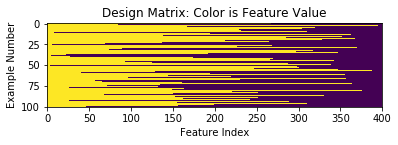

Hoping this is very close to 0:4.6884282980897267e-11
    param_l2reg  mean_test_score  mean_train_score
0      0.000001         0.172579          0.006752
1      0.000010         0.172464          0.006752
2      0.000100         0.171345          0.006774
3      0.001000         0.162705          0.008285
4      0.010000         0.141887          0.032767
5      0.100000         0.144566          0.094953
6      1.000000         0.171068          0.197694
7      1.300000         0.179521          0.216591
8      1.600000         0.187993          0.233450
9      1.900000         0.196361          0.248803
10     2.200000         0.204553          0.262958
11     2.500000         0.212530          0.276116
12     2.800000         0.220271          0.288422


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


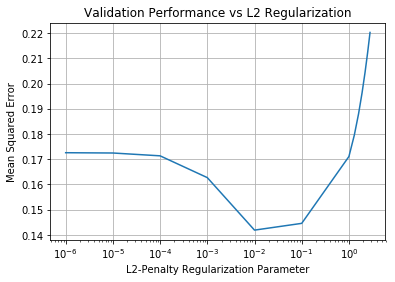

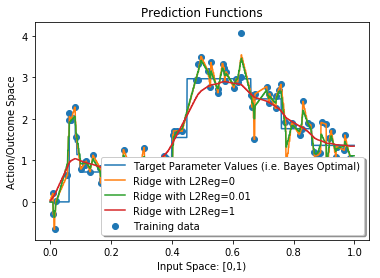

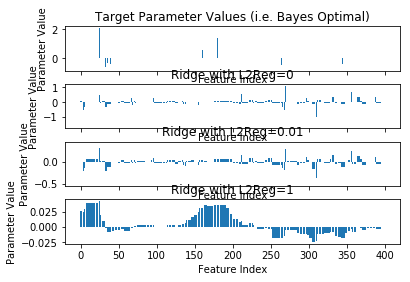

In [3]:
"""
Ridge regression using scipy's minimize function and demonstrating the use of
sklearn's framework.

Author: David S. Rosenberg <david.davidr@gmail.com>
License: Creative Commons Attribution 4.0 International License
"""
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd

from setup_problem import load_problem

class RidgeRegression(BaseEstimator, RegressorMixin):
    """ ridge regression"""

    def __init__(self, l2reg=1):
        if l2reg < 0:
            raise ValueError('Regularization penalty should be at least 0.')
        self.l2reg = l2reg

    def fit(self, X, y=None):
        n, num_ftrs = X.shape
        # convert y to 1-dim array, in case we're given a column vector
        y = y.reshape(-1)
        def ridge_obj(w):
            predictions = np.dot(X,w)
            residual = y - predictions
            empirical_risk = np.sum(residual**2) / n
            l2_norm_squared = np.sum(w**2)
            objective = empirical_risk + self.l2reg * l2_norm_squared
            return objective
        self.ridge_obj_ = ridge_obj

        w_0 = np.zeros(num_ftrs)
        self.w_ = minimize(ridge_obj, w_0).x
        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        return np.dot(X, self.w_)

    def score(self, X, y):
        # Average square error
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        residuals = self.predict(X) - y
        return np.dot(residuals, residuals)/len(y)



def compare_our_ridge_with_sklearn(X_train, y_train, l2_reg=1):
    # First run sklearn ridge regression and extract the coefficients
    from sklearn.linear_model import Ridge
    # Fit with sklearn -- need to multiply l2_reg by sample size, since their
    # objective function has the total square loss, rather than average square
    # loss.
    n = X_train.shape[0]
    sklearn_ridge = Ridge(alpha=n*l2_reg, fit_intercept=False, normalize=False)
    sklearn_ridge.fit(X_train, y_train)
    sklearn_ridge_coefs = sklearn_ridge.coef_

    # Now run our ridge regression and compare the coefficients to sklearn's
    ridge_regression_estimator = RidgeRegression(l2reg=l2_reg)
    ridge_regression_estimator.fit(X_train, y_train)
    our_coefs = ridge_regression_estimator.w_

    print("Hoping this is very close to 0:{}".format(np.sum((our_coefs - sklearn_ridge_coefs)**2)))

def do_grid_search_ridge(X_train, y_train, X_val, y_val):
    # Now let's use sklearn to help us do hyperparameter tuning
    # GridSearchCv.fit by default splits the data into training and
    # validation itself; we want to use our own splits, so we need to stack our
    # training and validation sets together, and supply an index
    # (validation_fold) to specify which entries are train and which are
    # validation.
    X_train_val = np.vstack((X_train, X_val))
    y_train_val = np.concatenate((y_train, y_val))
    val_fold = [-1]*len(X_train) + [0]*len(X_val) #0 corresponds to validation

    # Now we set up and do the grid search over l2reg. The np.concatenate
    # command illustrates my search for the best hyperparameter. In each line,
    # I'm zooming in to a particular hyperparameter range that showed promise
    # in the previous grid. This approach works reasonably well when
    # performance is convex as a function of the hyperparameter, which it seems
    # to be here.
    param_grid = [{'l2reg':np.unique(np.concatenate((10.**np.arange(-6,1,1),
                                           np.arange(1,3,.3)
                                             ))) }]

    ridge_regression_estimator = RidgeRegression()
    grid = GridSearchCV(ridge_regression_estimator,
                        param_grid,
                        return_train_score=True,
                        cv = PredefinedSplit(test_fold=val_fold),
                        refit = True,
                        scoring = make_scorer(mean_squared_error,
                                              greater_is_better = False))
    grid.fit(X_train_val, y_train_val)

    df = pd.DataFrame(grid.cv_results_)
    # Flip sign of score back, because GridSearchCV likes to maximize,
    # so it flips the sign of the score if "greater_is_better=FALSE"
    df['mean_test_score'] = -df['mean_test_score']
    df['mean_train_score'] = -df['mean_train_score']
    cols_to_keep = ["param_l2reg", "mean_test_score","mean_train_score"]
    df_toshow = df[cols_to_keep].fillna('-')
    df_toshow = df_toshow.sort_values(by=["param_l2reg"])
    return grid, df_toshow

def compare_parameter_vectors(pred_fns):
    # Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
    # "coefs" key
    fig, axs = plt.subplots(len(pred_fns),1, sharex=True)
    num_ftrs = len(pred_fns[0]["coefs"])
    for i in range(len(pred_fns)):
        title = pred_fns[i]["name"]
        coef_vals = pred_fns[i]["coefs"]
        axs[i].bar(range(num_ftrs), coef_vals)
        axs[i].set_xlabel('Feature Index')
        axs[i].set_ylabel('Parameter Value')
        axs[i].set_title(title)

    fig.subplots_adjust(hspace=0.3)
    return fig

def plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best"):
    # Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
    # "preds" key. The value corresponding to the "preds" key is an array of
    # predictions corresponding to the input vector x. x_train and y_train are
    # the input and output values for the training data
    fig, ax = plt.subplots()
    ax.set_xlabel('Input Space: [0,1)')
    ax.set_ylabel('Action/Outcome Space')
    ax.set_title("Prediction Functions")
    plt.scatter(x_train, y_train, label='Training data')
    for i in range(len(pred_fns)):
        ax.plot(x, pred_fns[i]["preds"], label=pred_fns[i]["name"])
    legend = ax.legend(loc=legend_loc, shadow=True)
    return fig

# # def main():
lasso_data_fname = "lasso_data.pickle"
x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(lasso_data_fname)

    # Generate features
X_train = featurize(x_train)
X_val = featurize(x_val)

#     #Visualize training data
fig, ax = plt.subplots()
ax.imshow(X_train)
ax.set_title("Design Matrix: Color is Feature Value")
ax.set_xlabel("Feature Index")
ax.set_ylabel("Example Number")
plt.show(block=False)

    # Compare our RidgeRegression to sklearn's.
compare_our_ridge_with_sklearn(X_train, y_train, l2_reg = 1.5)

    # Do hyperparameter tuning with our ridge regression
grid, results = do_grid_search_ridge(X_train, y_train, X_val, y_val)
print(results)

    # Plot validation performance vs regularization parameter
fig, ax = plt.subplots()
#    ax.loglog(results["param_l2reg"], results["mean_test_score"])
ax.semilogx(results["param_l2reg"], results["mean_test_score"])
ax.grid()
ax.set_title("Validation Performance vs L2 Regularization")
ax.set_xlabel("L2-Penalty Regularization Parameter")
ax.set_ylabel("Mean Squared Error")
fig.show()

    # Let's plot prediction functions and compare coefficients for several fits
    # and the target function.
pred_fns = []
x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
name = "Target Parameter Values (i.e. Bayes Optimal)"
pred_fns.append({"name":name, "coefs":coefs_true, "preds": target_fn(x) })
l2regs = [0, grid.best_params_['l2reg'], 1]
X = featurize(x)
for l2reg in l2regs:
    ridge_regression_estimator = RidgeRegression(l2reg=l2reg)
    ridge_regression_estimator.fit(X_train, y_train)
    name = "Ridge with L2Reg="+str(l2reg)
    pred_fns.append({"name":name,
                     "coefs":ridge_regression_estimator.w_,
                     "preds": ridge_regression_estimator.predict(X) })

f =plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")
f.show()

f = compare_parameter_vectors(pred_fns)
f.show()

# if __name__ == '__main__':
#     main()

In [4]:
#cyclic
def lasso_shooting_c(X,y,w,lambda_reg=0.05,max_steps = 1000,tolerence = 1e-8):
    converge = False
    steps = 0
    n = X.shape[0]
    d = X.shape[1]
    a = np.zeros(d)
    c = np.zeros(d)
    loss = np.dot(np.dot(X,w)-y, np.dot(X,w)-y)+lambda_reg*np.linalg.norm(w, ord=1)
    def soft(a,delta):
        sign_a = np.sign(a)
        if np.abs(a)-delta <0:
            return 0 
        else:
            return sign_a*(abs(a)-delta)
    while converge==False and steps<max_steps:
        loss_old = loss
        for j in range(d):
            a[j] =2*np.dot(X.T[j],X.T[j])
            c[j] =2*np.dot((y-np.dot(X,w)+w[j]*X.T[j]),X.T[j])
            if a[j] == 0 and c[j]==0:
                w[j]=0
            else:
                w[j] = soft(c[j]/a[j],lambda_reg/a[j])
        loss = np.dot(np.dot(X,w)-y, np.dot(X,w)-y)+lambda_reg*np.linalg.norm(w, ord=1)
        convergence = np.abs(loss_old-loss)<tolerence
        steps +=1
    return a,c,w

In [5]:
#randomlized
def lasso_shooting_r(X,y,w,lambda_reg=0.05,max_steps = 1000,tolerence = 1e-8):
    converge = False
    steps = 0
    n = X.shape[0]
    d = X.shape[1]
    a = np.zeros(d)
    c = np.zeros(d)
    loss = np.dot(np.dot(X,w)-y, np.dot(X,w)-y)+lambda_reg*abs(w)+lambda_reg*np.linalg.norm(w, ord=1)
    def soft(a,delta):
        sign_a = np.sign(a)
        if np.abs(a)-delta <0:
            return 0 
        else:
            return sign_a*(abs(a)-delta)
    while converge==False and steps<max_steps:
        loss_old = loss
        s=np.arange(n)
        np.random.shuffle(s)
        X=X[s]
        y=y[s]
        for j in range(d):
            a[j] =2*np.dot(X.T[j],X.T[j])
            c[j] =2*np.dot((y-np.dot(X,w)+w[j]*X.T[j]),X.T[j])
            if a[j] == 0 and c[j]==0:
                w[j]=0
            else:
                w[j] = soft(c[j]/a[j],lambda_reg/a[j])
        loss = np.dot(np.dot(X,w)-y, np.dot(X,w)-y)+lambda_reg*np.linalg.norm(w, ord=1)
        convergence = np.abs(loss_old-loss)<tolerence
        steps +=1
    return a,c,w


In [7]:
w = coefs_true
ridge_regression_estimator = RidgeRegression(l2reg=0.05)
ridge_regression_estimator.fit(X_train, y_train)
w_preds = ridge_regression_estimator.w_

In [8]:
#cyclic, ridge optimal
w=lasso_shooting_c(X_train,y_train,w_preds,lambda_reg=0.05,max_steps = 1000,tolerence = 1e-8)[2]
loss_val = np.dot(np.dot(X_val,w)-y_val,np.dot(X_val,w)-y_val)
print(loss_val)


148.83450194582917


In [9]:
#cyclic,0
w=lasso_shooting_c(X_train,y_train,np.zeros(400),lambda_reg=0.05,max_steps = 1000,tolerence = 1e-8)[2]
loss_val_ = np.dot(np.dot(X_val,w)-y_val,np.dot(X_val,w)-y_val)
print(loss_val_)


194.16970178765933


In [10]:
#randomlized, ridge optimal
w=lasso_shooting_r(X_train,y_train,w_preds,lambda_reg=0.05,max_steps = 1000,tolerence = 1e-8)[2]
loss_val = np.dot(np.dot(X_val,w)-y_val,np.dot(X_val,w)-y_val)
print(loss_val)

148.82459839722134


In [11]:
#randomlized, 0
w=lasso_shooting_r(X_train,y_train,np.zeros(400),lambda_reg=0.05,max_steps = 1000,tolerence = 1e-8)[2]
loss_val_ = np.dot(np.dot(X_val,w)-y_val,np.dot(X_val,w)-y_val)
print(loss_val_)


194.16970178765882


In [12]:
l1regs = [1e-7,1e-5,1e-4,1e-3,5e-3,1e-2,0.05,0.1,0.5,1,10,100]
ER_list=[]
for l1reg in l1regs:
    w=lasso_shooting_r(X_train,y_train,w_preds,
                     lambda_reg=l1reg,max_steps = 1000,tolerence = 1e-8)[2]
    ER = np.dot(np.dot(X_val,w)-y_val, np.dot(X_val,w)-y_val)
    ER_list.append(ER)
df = pd.DataFrame(list(zip(l1regs,ER_list)),columns=['l1regs','empirical risk'])
df

,l1regs,empirical risk
0,1.000000e-07,157.553704
1,1.000000e-05,157.551591
2,1.000000e-04,157.533962
3,1.000000e-03,157.358178
4,5.000000e-03,156.586407
5,1.000000e-02,155.640596
6,5.000000e-02,148.824877
7,1.000000e-01,142.545653
8,5.000000e-01,120.868693
9,1.000000e+00,114.782651


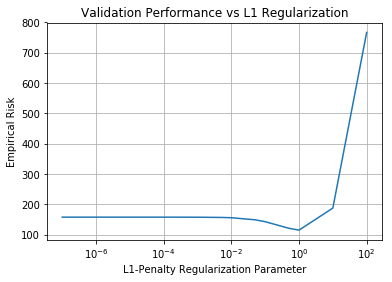

In [13]:
fig, ax = plt.subplots()
ax.semilogx(l1regs, ER_list)
ax.grid()
ax.set_title("Validation Performance vs L1 Regularization")
ax.set_xlabel("L1-Penalty Regularization Parameter")
ax.set_ylabel("Empirical Risk")
fig.show()

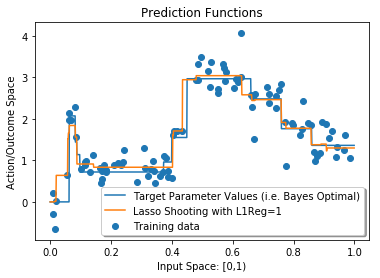

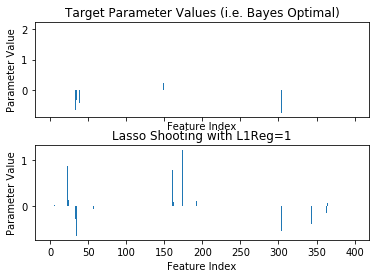

In [14]:
pred_fns = []
x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
name = "Target Parameter Values (i.e. Bayes Optimal)"
pred_fns.append({"name":name, "coefs":coefs_true, "preds": target_fn(x) })
X = featurize(x)
name = "Lasso Shooting with L1Reg="+str(1)
w=lasso_shooting_c(X_train,y_train,ridge_regression_estimator.w_,
                     lambda_reg=1,max_steps = 1000,tolerence = 1e-8)[2]
pred_fns.append({"name":name,
                 "coefs": w,
                 "preds": np.dot(X,w) })

f = plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")
f.show()

f = compare_parameter_vectors(pred_fns)
f.show()

In [15]:
lambda_max = max(2*np.abs(X_train.T.dot(y_train)))
lambda_lasso= [lambda_max*0.8**i for i in range(30)]
lambda_lasso
def warm_start(X,y,lambda_reg):
    w=np.zeros((30,400))
    loss=np.zeros(30)
    for i in range(30):
        w[i]= lasso_shooting_c(X,y,w[i-1],lambda_reg[i],
                             max_steps = 1000,tolerence = 1e-8)[2]
        loss[i] = 1/len(y_val)*np.dot(np.dot(X_val,w[i])-y_val,
                                      np.dot(X_val,w[i])-y_val)
    return loss

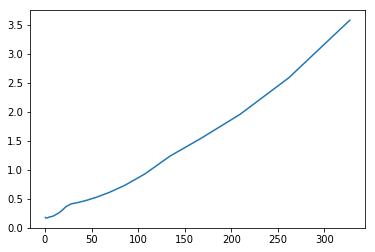

In [16]:
plt.plot(lambda_lasso,warm_start(X_train,y_train,lambda_lasso))

In [18]:
l2regs = [1e-7,1e-5,1e-4,1e-3,5e-3,1e-2,0.05,0.1,0.5,1,10]
ER_list=[]
for l2reg in l2regs:
    ridge_regression_estimator = RidgeRegression(l2reg=l2reg)
    ridge_regression_estimator.fit(X_train, y_train)
    w_opt= ridge_regression_estimator.w_
    ER = 1/len(y_val)*np.dot(np.dot(w_opt,X_val.T)-y_val, 
                             np.dot(w_opt,X_val.T)-y_val)
    ER_list.append(ER)
df = pd.DataFrame(list(zip(l2regs,ER_list)),columns=['l2regs','empirical risk'])
df

,l2regs,empirical risk
0,1.000000e-07,0.172590
1,1.000000e-05,0.172464
2,1.000000e-04,0.171345
3,1.000000e-03,0.162705
4,5.000000e-03,0.147317
5,1.000000e-02,0.141887
6,5.000000e-02,0.141019
7,1.000000e-01,0.144566
8,5.000000e-01,0.157506
9,1.000000e+00,0.171068


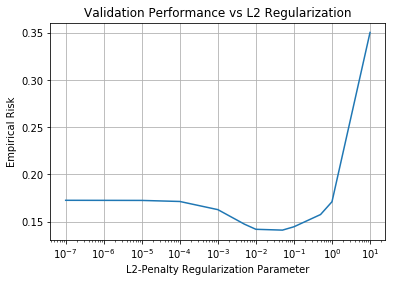

In [19]:
fig, ax = plt.subplots()
ax.semilogx(l2regs, ER_list)
ax.grid()
ax.set_title("Validation Performance vs L2 Regularization")
ax.set_xlabel("L2-Penalty Regularization Parameter")
ax.set_ylabel("Empirical Risk")
fig.show()

In [20]:
w = coefs_true

In [21]:
w_true= [(lambda i: 0 if i==0 else 1)(i) for i in w]
w_0 = [(lambda i: 0 if np.abs(i) < 1e-6 else 1)(i) for i in w_preds]
w_1 = [(lambda i: 0 if np.abs(i) < 1e-3 else 1)(i) for i in w_preds]
w_2 = [(lambda i: 0 if np.abs(i) < 1e-1 else 1)(i) for i in w_preds]

In [22]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, title, classes):      
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)     
    plt.title(title)       
    plt.colorbar()     
    tick_marks = np.arange(len(classes))       
    plt.xticks(tick_marks, classes, rotation=45)       
    plt.yticks(tick_marks, classes)        
    thresh = cm.max() / 2.        
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):  
        plt.text(j, i, format(cm[i, j], 'd'),  
                 horizontalalignment="center",  
                 color="white" if cm[i, j] > thresh else "black")      

    plt.tight_layout()        
    plt.ylabel('True label')       
    plt.xlabel('Predicted label')

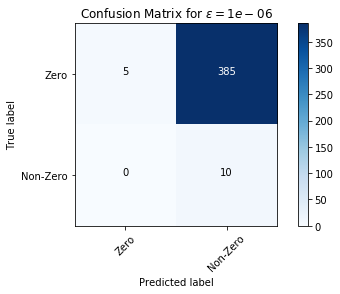

In [23]:
w = coefs_true
ridge_regression_estimator = RidgeRegression(l2reg=0.05)
ridge_regression_estimator.fit(X_train, y_train)
w_preds = ridge_regression_estimator.w_
w_true= [(lambda i: 0 if i==0 else 1)(i) for i in w]
w_0 = [(lambda i: 0 if np.abs(i) < 1e-6 else 1)(i) for i in w_preds]
w_1 = [(lambda i: 0 if np.abs(i) < 1e-3 else 1)(i) for i in w_preds]
w_2 = [(lambda i: 0 if np.abs(i) < 1e-1 else 1)(i) for i in w_preds]
eps = 1e-6;
cnf_matrix = confusion_matrix(w_true,w_0)
plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      title="Confusion Matrix for $\epsilon = {}$".format(eps), 
                      classes=["Zero", "Non-Zero"])
plt.show()

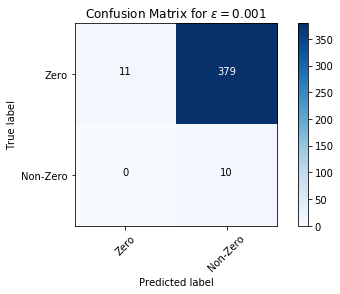

In [24]:
eps = 1e-3
cnf_matrix = confusion_matrix(w_true,w_1)
plt.figure()
plot_confusion_matrix(cnf_matrix, title="Confusion Matrix for $\epsilon = {}$".format(eps), classes=["Zero", "Non-Zero"])
plt.show()

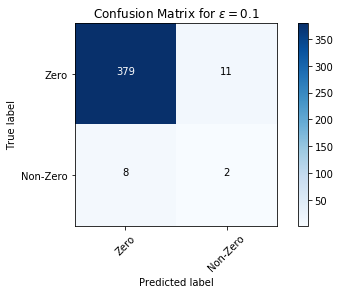

In [25]:
eps = 1e-1
cnf_matrix = confusion_matrix(w_true,w_2)
plt.figure()
plot_confusion_matrix(cnf_matrix, title="Confusion Matrix for $\epsilon = {}$".format(eps), classes=["Zero", "Non-Zero"])
plt.show()

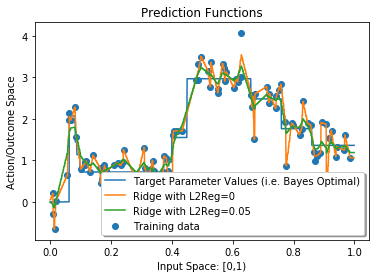

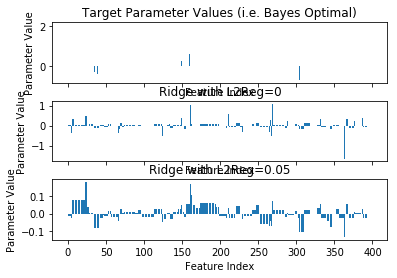

In [26]:
predict_fns = []
x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
name = "Target Parameter Values (i.e. Bayes Optimal)"
predict_fns.append({"name":name, "coefs":coefs_true, "preds": target_fn(x) })
l2regs = [0, 0.05]
X = featurize(x)
for l2reg in l2regs:
    ridge_regression_estimator = RidgeRegression(l2reg=l2reg)
    ridge_regression_estimator.fit(X_train, y_train)
    name = "Ridge with L2Reg="+str(l2reg)
    predict_fns.append({"name":name,
                        "coefs":ridge_regression_estimator.w_,
                        "preds": ridge_regression_estimator.predict(X) })

f = plot_prediction_functions(x, predict_fns, x_train, y_train, legend_loc="best")
f.show()

f = compare_parameter_vectors(predict_fns)
f.show()

In [34]:
print(np.argmax(np.abs(coefs_true)), np.max(np.abs(coefs_true)))
print(np.argmax(np.abs(w_unreg)),np.max(np.abs(w_unreg)))
print(np.argmax(np.abs(w_reg)),np.max(np.abs(w_reg)))


25 2.06957209208771
363 1.644220279957264
363 1.644220279957264


In [30]:
ridge_regression_estimator_reg = RidgeRegression(l2reg=0.05)
ridge_regression_estimator.fit(X_train, y_train)

RidgeRegression(l2reg=0)

In [31]:
ridge_regression_estimator_unreg = RidgeRegression(l2reg=0)
ridge_regression_estimator.fit(X_train, y_train)

RidgeRegression(l2reg=0)

In [32]:
w_unreg=ridge_regression_estimator.w_

In [33]:
w_reg=ridge_regression_estimator.w_